# Audience judgements of motion

Consider how participants moved during the concert and how these compare to their ratings of their own and each others (neighbours) movements during music listening.

1. Pull up the motion measurements and segment per piece (remote and hall?)
2. Pull up Questionnaire responses about how they moved
3. Check summary stats on movement behaviour relative to ratings per question
4. Rank motion by participants, can we see what a lot of movement looks like, vs a little?

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [35]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
concert_times.iloc[:5]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Action,946.00,0
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Action,963.12,1
2021-10-26 17:36:53,-673.12,-673120,Danish,Speech,964.12,2
2021-10-26 17:37:10,-656.12,-656120,English,Speech,981.12,3
2021-10-26 17:37:20,-645.60,-645600,Danish,Speech,991.64,4


In [5]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only participants with aligned motion traces and questionnair responses
partDets = partDets.loc[partDets['Questionnaire_Language'].isin(['D','E']),:] # participants with at least some questionnaire responses
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ115,115,B,E,Q,0,NaN,Porto,41.0,-9.0,-6.32,NaN,1.0
108,BEQ116,116,B,E,Q,0,NaN,Montréal,46.0,-74.0,-30.66,NaN,1.0
109,BEQ117,117,B,E,Q,0,NaN,Stockholm,59.0,17.0,-10.22,NaN,1.0
110,BEQ118,118,B,E,Q,0,NaN,Portola Valley California,37.0,-122.0,-28.00,NaN,0.0


In [12]:
# load those motion traces 
# warning this takes a long time to process. I should save versions of this data so I don't need to reinterpoalte all the time. 

# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
tic = time.time()
for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,gap_t)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    #aud_df[part] = b
    # 214 s so longer to make and concat. hm
    if 'R' in part:
        rmov_one = pd.DataFrame(index = ts_ct, columns= [part], data = 6*b)
        aud_df=pd.concat([aud_df,rmov_one],axis=1)
    else:
        rmov_one = pd.DataFrame(index = ts_ct, columns= [part], data = b)
        aud_df=pd.concat([aud_df,rmov_one],axis=1)
        
        #183.92967629432678
#     if 'R' in part:
#         aud_df[part] =  b*6
#     else:
#         aud_df[part] = b        
    
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
    print(time.time()-tic)
        
aud_df.index = dt_ct

1.3586103916168213
2.4396002292633057
4.493621110916138
6.002751111984253
7.759248971939087
9.999252319335938
11.83339548110962
13.442626714706421
15.281309366226196
16.853505611419678
18.604538917541504
20.507516145706177
22.242353439331055
24.329344749450684
25.978588819503784
27.617602825164795
28.41759967803955
29.82495880126953
31.684307098388672
33.34864664077759
34.397619009017944
35.72480916976929
37.72237300872803
39.54316163063049
41.382726192474365
43.05412459373474
44.77761125564575
46.827311515808105
48.501788854599
50.353970766067505
52.151068449020386
53.21011829376221
54.77157926559448
56.35742402076721
58.175397872924805
59.90747666358948
61.796937227249146
63.912567138671875
65.32404160499573
67.2199490070343
69.54787802696228
71.75751686096191
73.73754811286926
76.0016782283783
77.42754626274109
79.66752552986145
81.82238793373108
84.14336895942688
86.132572889328
88.21048307418823
90.2318274974823
92.33266353607178
94.8386857509613
96.74798917770386
98.8181269168853

Normalising with  first minute of every music piece. These are intevals in which participants were mostly still but also normalively moved. By taking the medium in these intervals (gathered across all performance) we get a standard close to the noise threshold with participants tendency to not move. 

Using specific segment of motion from begining (usually low motion) and across all pieces to reduce risk of favouring one piece over others. This is "normal" stillness.

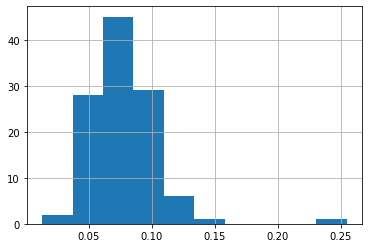

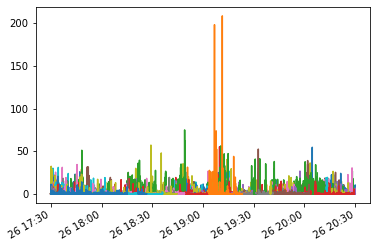

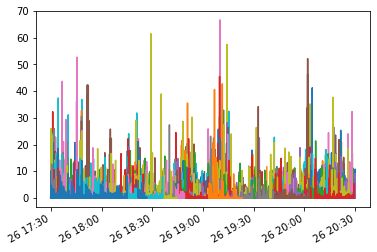

In [118]:
NT = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Event_Duration']

Scale_move = pd.DataFrame()
for i in range(len(NT)):
    Scale_move = pd.concat([Scale_move,aud_df.loc[NT.index[i]+pd.to_timedelta(10,unit='s'):NT.index[i]+pd.to_timedelta(100,unit='s')]],axis=0)

Scale_move.median().hist()
matched_median = Scale_move.median().median()
meds = Scale_move.median()

alt_aud_df = aud_df.copy()

for c in alt_aud_df.columns:
    alt_aud_df[c] = matched_median*aud_df[c]/meds[c]

alt_aud_df.plot(legend = False)
plt.show()
aud_df.plot(legend = False)
plt.show()

<AxesSubplot:>

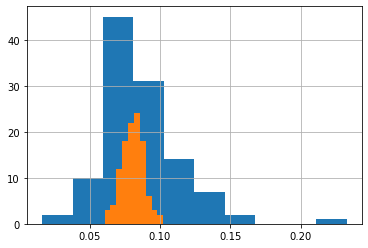

In [120]:
# normalisatin test
ax = aud_df.quantile(0.5).hist()
alt_aud_df.quantile(0.5).hist(ax=ax)

In [119]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

## Normalisation for motion measurements

We really need to bring the motion measurements into a similar range of values that are comparable over time and between participants.

In theory, there are a few contributors of signal value changes in these measurements:

1. Sensor noise: dependent on the measurement device, so the amplitude will differ between participants, but this is the small jitter in values that is present across all movement conditions. This should be noticiable in differences from sample to sample, so at the initial near 60 Hz rate. We want to reduce this to nothing if possible.

2. Small displacement: Movements at a slower rate than sensor noise, trajectories in 250-10000 ms with mostly small amplitudes, often involuntary, at least during passive music listening. This need to be brought into a comparable range between participants, but not necessarily matched in distribution. Maybe match at lower range and check that scale isn't off the charts different (factor of 10). 

3. Clapping: 4-2 Hz oscillation for sustained period, 2-80 seconds, with some variation in intensity (amplitude). Participants movement recordings can be scaled to the range of common values. Everyone should have calm claps, some may have more time in the extremely excited range, so normalised by 25th percentile? 

4. Big displacement: One off displacements at rate of one or twice every 2-30 minutes. These are changes in seating or posture that are triggers for behaviour change and rare during music listening but common before and after performances. Not garaunteed in all movement recordings. Nor is it certain they should be matched between participants, but can be a check on scale.

So, ideas about making things work: look at cummulative distributions of first order differences with different sample rates
    50 Hz, 10 Hz, 1 Hz, 0.1 Hz. 
    
Test on pairs of recordings to bring parameters into focus: noise suppression, range alignment, truncation on extremes.

In [121]:
def stats_ts(df):
    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    return stats_df

In [122]:
NT = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Event_Duration']

Scale_move = pd.DataFrame()
for i in range(len(NT)):
    Scale_move = pd.concat([Scale_move,aud_df.loc[NT.index[i]:NT.index[i]+pd.to_timedelta(60,unit='s')]],axis=0)

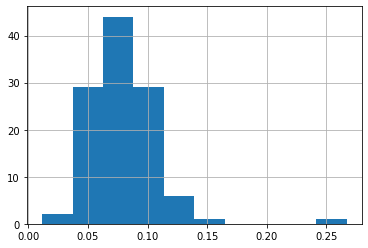

In [79]:
Scale_move.median().hist()
matched_median = Scale_move.median().median()
meds = Scale_move.median()

In [80]:
Scale_moved = Scale_move.copy()
for c in Scale_moved.columns:
    Scale_moved.loc[:,c] = matched_median*Scale_move[c]/meds[c]

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2234204641.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

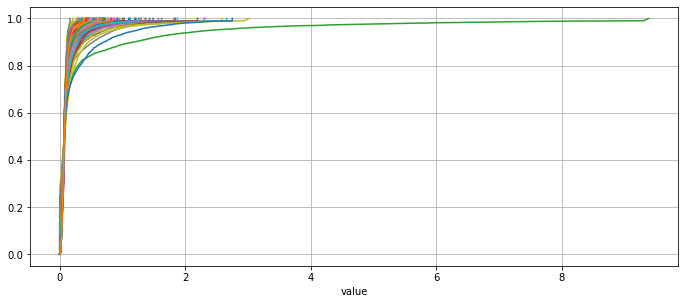

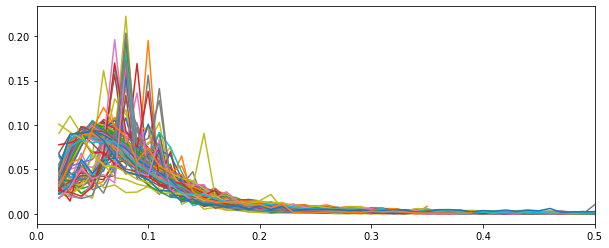

In [123]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(Scale_moved.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')

for c in Scale_moved.columns:
    s = pd.Series(Scale_moved[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
    
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\2550303591.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

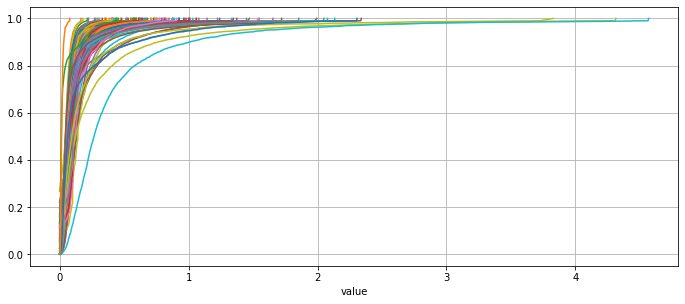

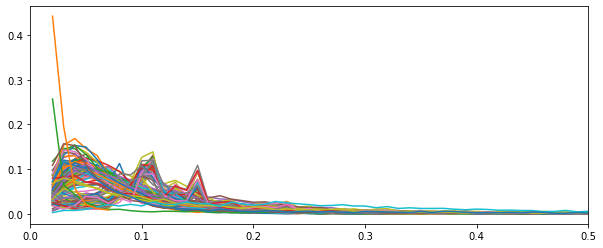

In [124]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(Scale_move.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')

for c in Scale_move.columns:
    s = pd.Series(Scale_move[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
    
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\1578668856.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

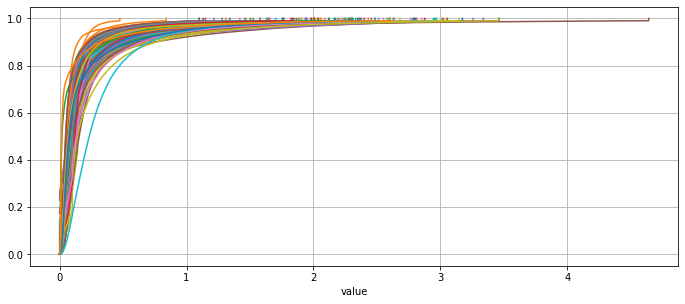

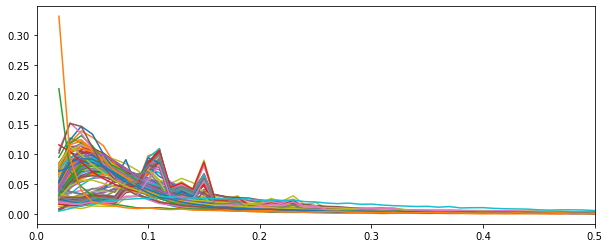

In [125]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(aud_df.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')
for c in aud_df.columns:
    s = pd.Series(aud_df[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdfs_df[c] = f(x_cdf)
C:\Users\finnu\AppData\Local\Temp\ipykernel_12964\3488049862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

(0.0, 0.5)

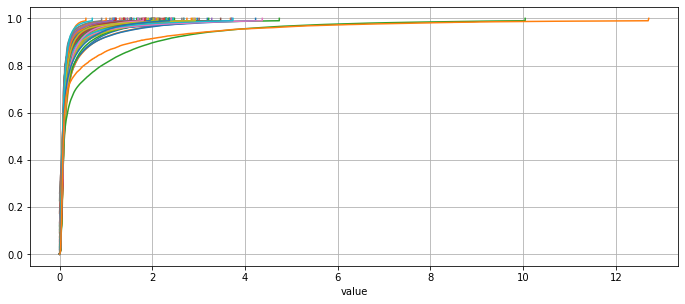

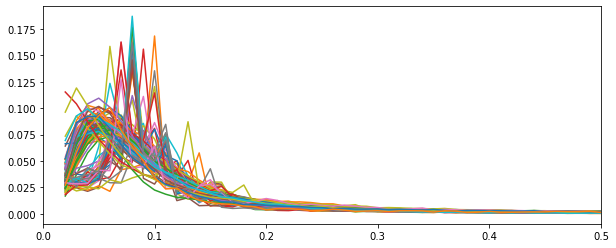

In [126]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_cdf = np.arange(0.01,5,0.01)
s = pd.Series(alt_aud_df.iloc[:,1], name = 'value')
df = pd.DataFrame(s)
cdfs_df = pd.DataFrame(index =x_cdf)
stats_df = stats_ts(df)
f = interpolate.interp1d(stats_df['cdf'], stats_df['value'],fill_value='extrapolate')
for c in aud_df.columns:
    s = pd.Series(alt_aud_df[c], name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c] = f(x_cdf)
    stats_df.plot(x = 'value', y = 'cdf',label = c, grid = True,ax=ax,legend = False)
cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,0.5])

In [ ]:
#norm test for aud_df


here we have at least three different patterns of behaviour
those that have mostly zeros
those that have a noise peak around 0.02
those that have a noise peak around 0.1, but sharply (might be the Androids with the sharp presision limit)

might also want to describe the gradual peaks around 0.1  

we can assume these are the noise characteristics that would be worth flattening away 

what happens if we cut noise at twice peak? 
Thresh is min([2*(resampled pdf),quantile(q=0.75)])

<AxesSubplot:>

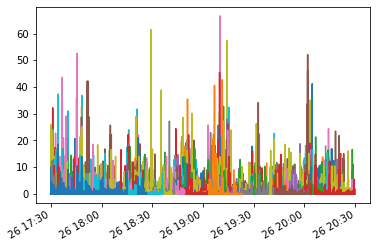

In [371]:
# 2*cdfs_df.diff().idxmax()
# mus_cat.quantile(q=0.6)
alt_aud_df = aud_df.copy()
for c in alt_aud_df.columns:
    thr = min([2*cdfs_df[c].diff().idxmax(),mus_cat[c].quantile(q=0.6)])
    alt_aud_df[c] =  alt_aud_df[c] - thr
    alt_aud_df.loc[alt_aud_df[c]<0,c] = np.nan
alt_aud_df.plot(legend = False)

In [127]:
partDets.loc[partDets['Attendance'].isin(['A']),'Participant_Code'].values

array(['ADQ001', 'ADQ002', 'ADQ003', 'ADQ004', 'ADQ005', 'ADQ006',
       'ADQ007', 'ADQ008', 'ADQ009', 'ADQ010', 'ADQ011', 'ADQ012',
       'ADQ013', 'ADQ014', 'ADQ015', 'ADQ016', 'ADQ017', 'ADQ018',
       'ADQ019', 'ADQ020', 'ADQ021', 'ADQ022', 'ADQ023', 'ADQ024',
       'ADQ025', 'ADQ026', 'ADQ027', 'ADQ028', 'ADQ029', 'ADQ030',
       'ADQ031', 'ADQ032', 'ADQ033', 'ADQ034', 'ADQ035', 'ADQ036',
       'ADQ037', 'ADQ038', 'ADQ039', 'ADQ040', 'ADQ041', 'ADQ042',
       'ADQ043', 'ADQ044', 'ADQ045', 'ADQ046', 'ADQ047', 'ADQ048',
       'ADQ049', 'ADQ050', 'ADQ051', 'ADQ052', 'ADQ053', 'ADQ054',
       'ADQ055', 'ADQ056', 'ADQ057', 'ADQ058', 'ADQ059', 'ADQ060',
       'ADQ061', 'ADQ062', 'ADQ063', 'ADQ064', 'ADQ065', 'ADQ066',
       'ADR067', 'ADR068', 'ADR069', 'ADR070', 'ADR071', 'ADS072',
       'ADS073', 'ADS074', 'ADT075', 'ADU076', 'AEQ077', 'AEQ078',
       'AEQ079', 'AEQ080', 'AEQ081', 'AEQ082', 'AEQ083', 'AEQ084',
       'AEQ085', 'AEQ086', 'AEQ087', 'AEQ088', 'AEQ089', 'AER0

array([ 1.        ,  0.76756551,  4.89054459, 22.21957139, 43.65223299])

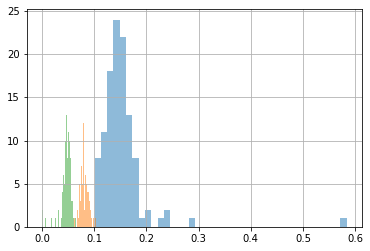

In [128]:
# array([ 1.        ,  1.5550507 ,  2.56791346, 10.57168739])
# array([ 1.        ,  0.82818318,  5.54803117, 24.12875715, 46.39970122])

# ax = alt_aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
# alt_aud_df.quantile(0.9).hist(bins=20,alpha=0.5)
ax = alt_aud_df.quantile(0.75).hist(bins=40,alpha=0.5)
alt_aud_df.quantile(0.5).hist(bins=40,alpha=0.5,ax=ax)
alt_aud_df.quantile(0.25).hist(bins=40,alpha=0.5,ax=ax)
np.array([alt_aud_df.quantile(0.25).std(),alt_aud_df.quantile(0.5).std(),alt_aud_df.quantile(0.75).std(),alt_aud_df.quantile(0.9).std(),alt_aud_df.quantile(0.95).std()])/alt_aud_df.quantile(0.25).std()

array([ 1.        ,  1.38131172,  2.54087101,  6.72760545, 11.85834897])

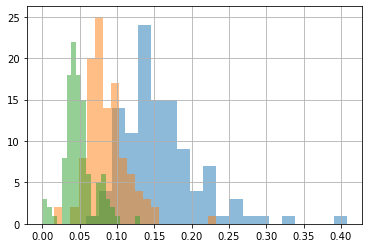

In [129]:
# original values
# ax = aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
# aud_df.quantile(0.9).hist(bins=20,alpha=0.5,ax=ax)
ax = aud_df.quantile(0.75).hist(bins=20,alpha=0.5)
aud_df.quantile(0.5).hist(bins=20,alpha=0.5,ax=ax)
aud_df.quantile(0.25).hist(bins=20,alpha=0.5,ax=ax)
np.array([aud_df.quantile(0.25).std(),aud_df.quantile(0.5).std(),aud_df.quantile(0.75).std(),aud_df.quantile(0.9).std(),aud_df.quantile(0.95).std()])/aud_df.quantile(0.25).std()

array([ 1.        ,  0.76756551,  4.89054459, 22.21957139, 43.65223299])

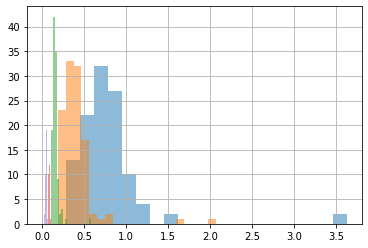

In [130]:
#array([ 1.        ,  1.49668896,  2.41030266,  6.03935999, 11.37886374])
# median on claps *10 thresh for in hall, quantile (0.85)*12 for remote
ax = alt_aud_df.quantile(0.95).hist(bins=20,alpha=0.5)
alt_aud_df.quantile(0.9).hist(bins=20,alpha=0.5)
alt_aud_df.quantile(0.75).hist(bins=20,alpha=0.5,ax=ax)
alt_aud_df.quantile(0.5).hist(bins=20,alpha=0.5,ax=ax)
alt_aud_df.quantile(0.25).hist(bins=20,alpha=0.5,ax=ax)
np.array([alt_aud_df.quantile(0.25).std(),alt_aud_df.quantile(0.5).std(),alt_aud_df.quantile(0.75).std(),alt_aud_df.quantile(0.9).std(),alt_aud_df.quantile(0.95).std()])/alt_aud_df.quantile(0.25).std()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 18:14:55')]


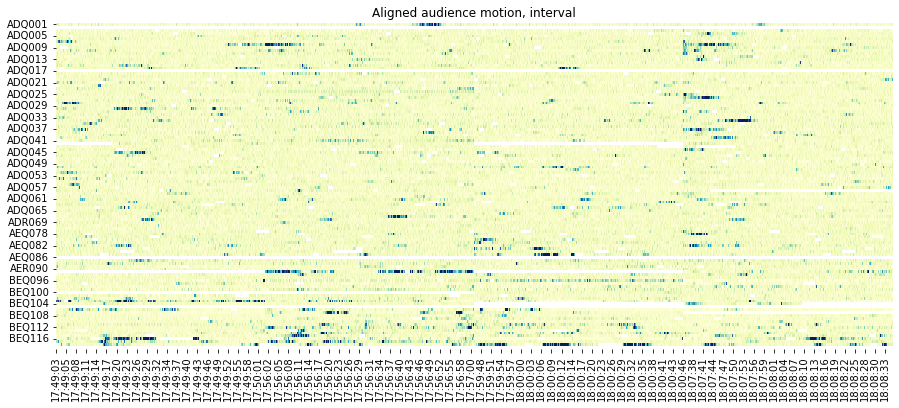

In [133]:
# # now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[60,:].name
print([seg_start,seg_end])

seg_df = Scale_moved.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
#sns.color_palette("flare", as_cmap=True)
#sns.color_palette("YlOrBr", as_cmap=True)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 18:14:55')]


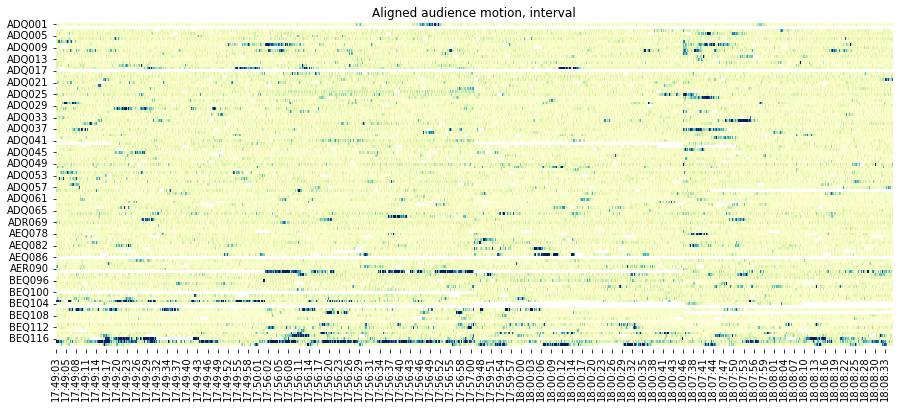

In [134]:
# # now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[60,:].name
print([seg_start,seg_end])

seg_df = Scale_move.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
#sns.color_palette("flare", as_cmap=True)
#sns.color_palette("YlOrBr", as_cmap=True)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:43:24')]


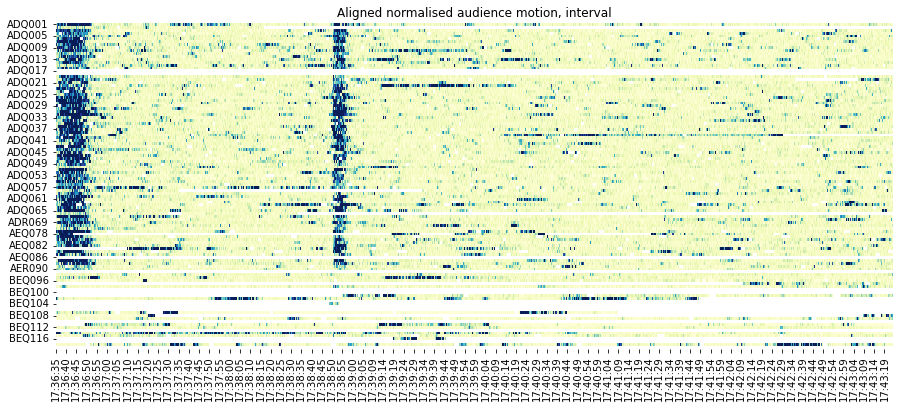

In [138]:
# now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[15,:].name
print([seg_start,seg_end])

seg_df = alt_aud_df.loc[seg_start:seg_end]

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned normalised audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:43:24')]


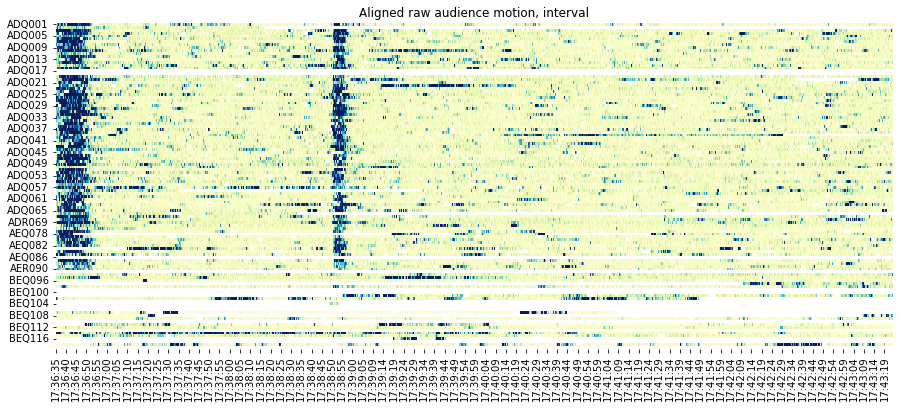

In [139]:
# now evaluate 
# original units
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[15,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned raw audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

### Consider normalising before quantity of motion at 10 Hz 

The distinction of noise and signal is may be easier to extract from original accelerometer values. QoM folds together noise in a way that can obfuscate.

In [13]:
# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

<AxesSubplot:>

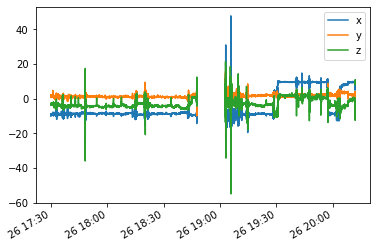

In [14]:
part = alignedParts.loc[6,'Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    C = 1
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    C = 8
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
# b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
resampled.index = dt_ct

resampled.loc[:,['x','y','z']].plot()

(0.0, 1.0)

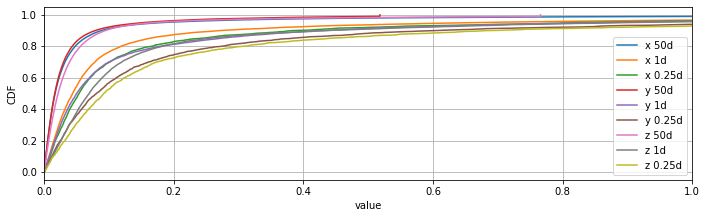

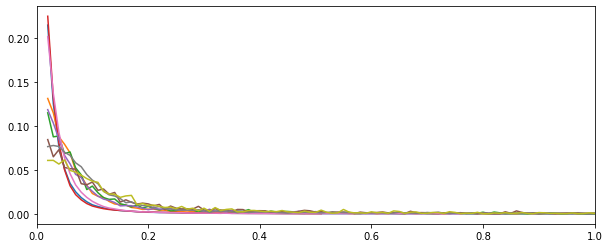

In [15]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_axes([0.1, 0.1, 0.9, 0.4])
# ax2 = fig.add_axes([0.1, 0.6, 0.9, 0.4])
x_cdf = np.arange(0.01,5,0.01)
cdfs_df = pd.DataFrame(index =x_cdf)

for c in ['x','y','z']:#resampled.columns:
    s = pd.Series(resampled[c].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    # Frequency
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+' 50d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+' 50d', grid = True,ax=ax1)
    ax1.set_ylabel('CDF')
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),50)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 1d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 1d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),200)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 0.25d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 0.25d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])

cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,1])

(0.0, 1.0)

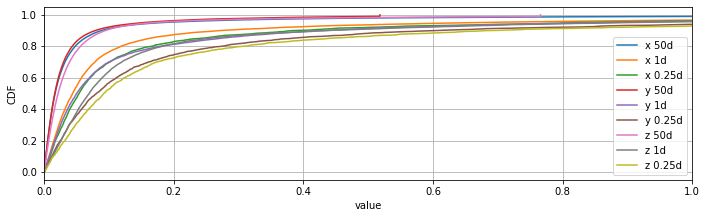

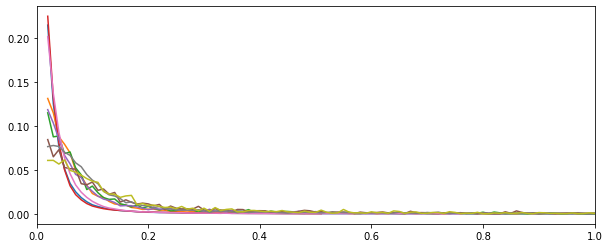

In [16]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_axes([0.1, 0.1, 0.9, 0.4])
# ax2 = fig.add_axes([0.1, 0.6, 0.9, 0.4])
x_cdf = np.arange(0.01,5,0.01)
cdfs_df = pd.DataFrame(index =x_cdf)

for c in ['x','y','z']:#resampled.columns:
    s = pd.Series(resampled[c].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    # Frequency
    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+' 50d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+' 50d', grid = True,ax=ax1)
    ax1.set_ylabel('CDF')
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),50)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 1d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 1d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])
    
    s = pd.Series(resampled[c].iloc[np.arange(1,len(resampled),200)].diff().abs(), name = 'value')
    df = pd.DataFrame(s)
    thr = df['value'].quantile(q=.99)
    df.loc[df['value']>thr,'value']= thr

    stats_df = stats_ts(df)
    f = interpolate.interp1d(stats_df['value'], stats_df['cdf'],bounds_error=False)
    cdfs_df[c+ ' 0.25d'] = f(x_cdf)
    # Plot
    stats_df.plot(x = 'value', y = 'cdf',label = c+ ' 0.25d', grid = True,ax=ax1)
    ax1.set_xlim([0,1])

cdfs_df.diff().plot(legend=False,figsize=[10,4])
plt.xlim([0,1])

<AxesSubplot:>

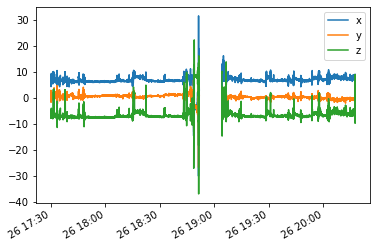

In [17]:
part = alignedParts.loc[8,'Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)
    
    

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
# b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
resampled.index = dt_ct

resampled.loc[:,['x','y','z']].plot()

## segmentation of motion recordings to music intervals content

In [140]:
# switch in perfered normalisation 
aud_df = alt_aud_df.copy()

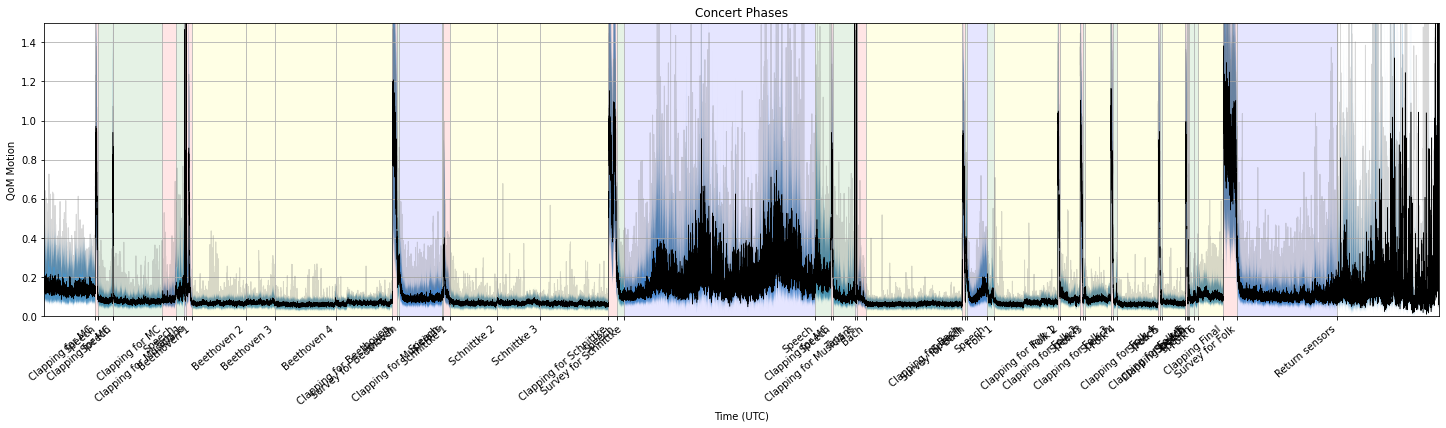

In [141]:
yrange = [0,1.5]
#aud_df.plot(ax=ax,linewidth=2,alpha=0.6,legend = False)

ax = aud_df.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=(25,6))
    
x = np.array(aud_df.index)
y1 = np.array(aud_df.quantile(q=0.25,axis = 1),dtype=np.float32)
y2 = np.array(aud_df.quantile(q=0.75,axis = 1),dtype=np.float32)
aud_df.median(axis=1).plot(color='k',linewidth=0.5)
ax.fill_between(x,y1,y2,alpha = 0.8)

ax.grid()
ax.set_title('Concert Phases')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('QoM Motion')
ax.set_ylim(yrange)
ax.set_xticks(Main_concert_times.index)
ax.set_xticklabels(Main_concert_times['Event'],rotation=40,ha='right')

ax.margins(0)

for i in range(len(Main_concert_times)-1):
    r= Main_concert_times.iloc[i,:]
    ei = r.name
    ej = Main_concert_times.index[i+1]
    if r['Event_Type'].startswith('Applause'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event_Type'].endswith('Music'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event_Type'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event_Type'].startswith('Synch'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

plt.savefig('Concert_Motion_Full_Central.png',dpi = 300)
plt.show()

In [142]:
concert_seg = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_seg

,Event,Time_dt_Start,Time_s_Start,Time_ms_Start,Time_Stream_Start,Time_dt_End,Time_s_End,Time_ms_End,Time_Stream_End,sequence,Event_Duration,Event_Type
0,Claps 1,2021-10-26 17:36:32.760,-693.24,-693240.0,946.00,2021-10-26 17:36:49.840,-676.16,-676160.0,963.08,0,17.08,Applause
1,MC Speach 1,2021-10-26 17:36:50.820,-675.18,-675180.0,964.06,2021-10-26 17:38:47.780,-558.22,-558220.0,1081.02,1,116.96,Speach
2,Claps 2,2021-10-26 17:38:47.960,-558.04,-558040.0,1081.20,2021-10-26 17:38:55.880,-550.12,-550120.0,1089.12,2,7.92,Applause
3,MC Speach 2,2021-10-26 17:38:53.840,-552.16,-552160.0,1087.08,2021-10-26 17:48:18.380,12.38,12380.0,1651.62,3,564.54,Speach
4,Synch cue 1,2021-10-26 17:47:58.840,-7.16,-7160.0,1632.08,2021-10-26 17:48:35.460,29.46,29460.0,1668.70,4,36.62,Synchronisation
5,Claps 3,2021-10-26 17:48:34.440,28.44,28440.0,1667.68,2021-10-26 17:48:44.360,38.36,38360.0,1677.60,5,9.92,Applause
6,Music Beethoven 1,2021-10-26 17:49:01.400,55.40,55400.0,1694.64,2021-10-26 17:55:41.840,455.84,455840.0,2095.08,6,400.44,Music
7,Music Beethoven 2,2021-10-26 17:56:00.260,474.26,474260.0,2113.50,2021-10-26 17:59:17.180,671.18,671180.0,2310.42,7,196.92,Music
8,Music Beethoven 3,2021-10-26 17:59:45.340,699.34,699340.0,2338.58,2021-10-26 18:07:17.820,1151.82,1151820.0,2791.06,8,452.48,Music
9,Music Beethoven 4,2021-10-26 18:07:34.100,1168.10,1168100.0,2807.34,2021-10-26 18:14:52.820,1606.82,1606820.0,3246.06,9,438.72,Music


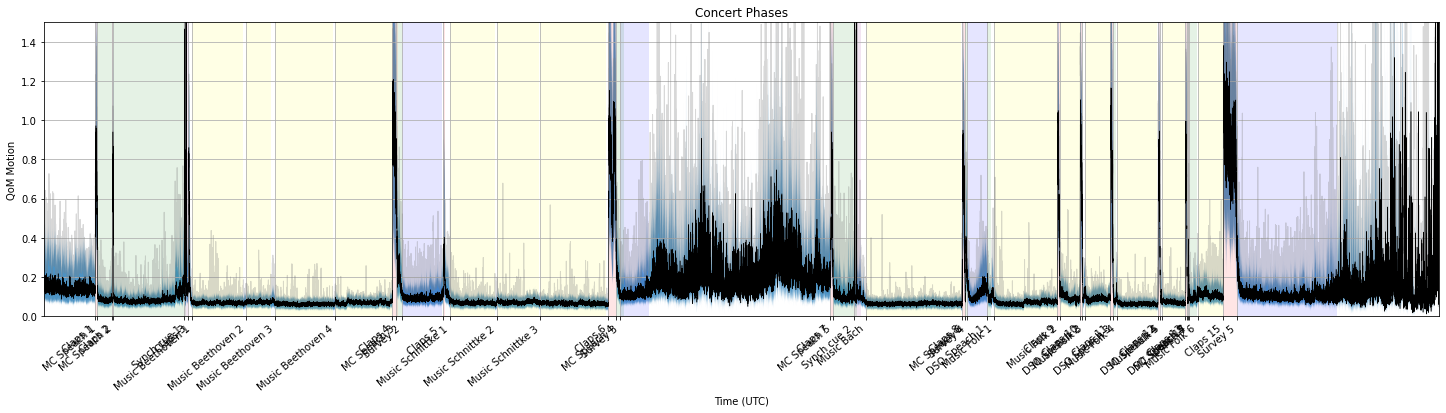

In [143]:
yrange = [0,1.5]
#aud_df.plot(ax=ax,linewidth=2,alpha=0.6,legend = False)

ax = aud_df.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=(25,6))
    
x = np.array(aud_df.index)
y1 = np.array(aud_df.quantile(q=0.25,axis = 1),dtype=np.float32)
y2 = np.array(aud_df.quantile(q=0.75,axis = 1),dtype=np.float32)
aud_df.median(axis=1).plot(color='k',linewidth=0.5)
ax.fill_between(x,y1,y2,alpha = 0.8)

ax.grid()
ax.set_title('Concert Phases')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('QoM Motion')
ax.set_ylim(yrange)
ax.set_xticks(concert_seg.Time_dt_Start)
ax.set_xticklabels(concert_seg['Event'],rotation=40,ha='right')

ax.margins(0)
for i in range(len(concert_seg)):
    r= concert_seg.iloc[i,:]
    ei = r.Time_dt_Start
    ej = r.Time_dt_End
    if r['Event_Type'].startswith('Applause'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event_Type'].endswith('Music'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speach'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event_Type'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event_Type'].startswith('Synch'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

plt.savefig('Concert_Motion_Full_Central.png',dpi = 300)
plt.show()

In [174]:
aud_df.median(axis=1).to_csv('Full_Mean.csv')

In [144]:
Main_concert_times['Event_Type'].value_counts()

Applause           17
Speech             16
Music              14
Survey              4
Synchronisation     2
End                 1
Name: Event_Type, dtype: int64

In [145]:
musics = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Music'),:]
Mus_DF = {}
Medians_df = pd.DataFrame(index = musics['Event'],columns = aud_df.columns)
mus_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in musics.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    mus_cat = pd.concat([mus_cat,seg_df])
    Medians_df.loc[m['Event'],:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    Mus_DF[m['Event']] = seg_df
    
    
len(Mus_DF)

14

In [146]:
Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Music'),:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,9
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,10
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music,2807.40,440.20,11
2021-10-26 18:22:20,2054.48,2054480,Schnittke 1,Music,3691.72,364.28,17
2021-10-26 18:28:25,2418.76,2418760,Schnittke 2,Music,4056.00,336.52,18
2021-10-26 18:34:01,2755.28,2755280,Schnittke 3,Music,4392.52,527.08,19
2021-10-26 19:16:00,5274.36,5274360,Bach,Music,6911.60,745.08,28
2021-10-26 19:32:37,6271.28,6271280,Folk 1,Music,7908.52,487.68,33


In [147]:
speeches = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Speech'),:]
Spe_DF = {}
Medians_df = pd.DataFrame(columns = aud_df.columns)
spe_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in speeches.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    spe_cat = pd.concat([spe_cat,seg_df])
    Medians_df.loc[m['Event']+str(i),:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    Spe_DF[m['Event']+str(i)] = seg_df
    
    
len(Spe_DF)

16

In [148]:
applauses = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Applause'),:]
App_DF = {}
Medians_df = pd.DataFrame(columns = aud_df.columns)
app_cat= pd.DataFrame(columns = aud_df.columns) 
for i,m in applauses.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    app_cat = pd.concat([app_cat,seg_df])
    Medians_df.loc[m['Event']+str(i),:] = seg_df.median()
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    App_DF[m['Event']+str(i)] = seg_df
    
    
len(App_DF)

17

<AxesSubplot:>

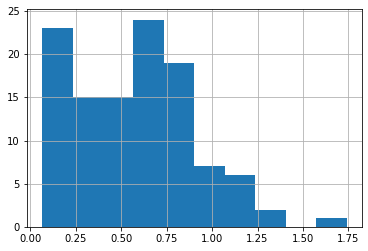

In [149]:
Medians_df.mean().hist()

<AxesSubplot:>

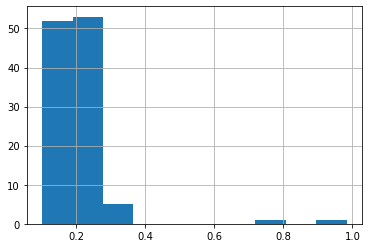

In [150]:
aud_df.mean().hist()

<AxesSubplot:>

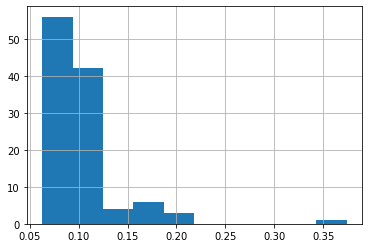

In [151]:
mus_cat.mean().hist()

<AxesSubplot:>

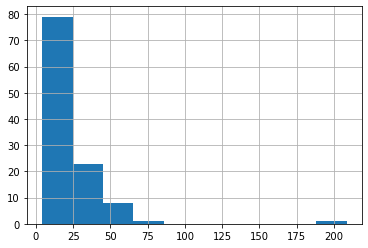

In [152]:
aud_df.max().hist()

<AxesSubplot:>

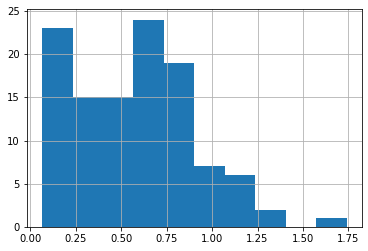

In [153]:
Medians_df.mean().hist()

In [154]:
list(Mus_DF)

['Beethoven 1',
 'Beethoven 2',
 'Beethoven 3',
 'Beethoven 4',
 'Schnittke 1',
 'Schnittke 2',
 'Schnittke 3',
 'Bach',
 'Folk 1',
 'Folk 2',
 'Folk 3',
 'Folk 4',
 'Folk 5',
 'Folk 6']

In [171]:
seg

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ103,BEQ105,BEQ106,BEQ107,BEQ108,BEQ109,BEQ110,BEQ111,BEQ112,BEQ113
2021-10-26 19:58:21.099999992,2.113095,0.011846,0.000000,0.252306,NaN,0.000000,0.126089,0.280260,0.041234,0.082144,...,0.436885,0.074371,0.206619,0.024454,0.495474,0.061294,0.244636,0.071664,0.084818,0.074174
2021-10-26 19:58:21.199999992,1.925638,0.011846,0.072449,0.648604,NaN,0.000000,0.102404,0.057789,0.076052,0.148917,...,1.979584,0.086163,0.207107,0.055084,0.184958,0.130140,0.195284,0.070438,0.101908,0.057774
2021-10-26 19:58:21.299999992,0.782747,0.071689,0.060234,0.580963,NaN,0.100704,0.160036,0.344196,0.067305,0.089200,...,0.294539,0.086163,0.165117,0.071150,0.192647,0.122415,0.178927,0.099838,0.138352,0.056220
2021-10-26 19:58:21.399999992,1.327047,0.063378,0.089642,0.364178,NaN,0.159226,0.127857,0.370501,0.089244,0.170739,...,0.432657,0.105528,0.113023,0.134076,0.452612,0.064487,0.146771,0.059443,0.110710,0.025190
2021-10-26 19:58:21.499999992,1.868906,0.063378,0.071208,0.248191,NaN,0.100704,0.094784,0.167609,0.079836,0.139037,...,0.234030,0.074371,0.087700,0.142675,0.248622,0.067795,0.144024,0.146555,0.075772,0.054766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 19:58:50.599999992,0.969682,0.162151,0.088116,0.433126,0.129233,1.067179,0.206775,4.010661,0.508397,0.176386,...,0.138989,0.000000,0.343984,0.040237,0.259010,0.027527,0.379293,0.076585,0.038190,0.083495
2021-10-26 19:58:50.699999992,1.098840,0.348622,0.063458,0.458349,0.166483,0.609469,0.048579,1.866478,0.411166,0.213290,...,0.191523,0.000000,0.286097,0.013068,0.197429,0.041316,0.735284,0.078901,0.034533,0.055117
2021-10-26 19:58:50.799999992,0.777343,0.103099,0.062831,0.214324,0.164522,0.128219,0.095465,1.238150,0.291291,0.294051,...,0.051587,0.051698,0.214529,0.113460,0.121983,0.034105,0.205127,0.037183,0.032219,0.069044
2021-10-26 19:58:50.899999992,0.654039,0.263320,0.088488,0.807166,0.150798,0.452032,0.244529,0.759080,0.076537,0.211816,...,0.053804,0.051698,0.058260,0.083398,0.098754,0.076005,0.185981,0.038288,0.072019,0.053275


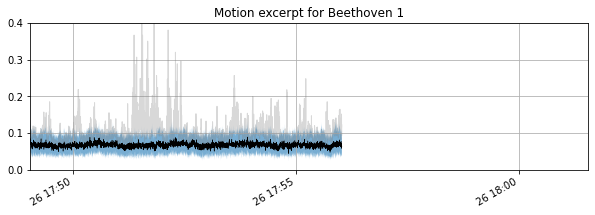

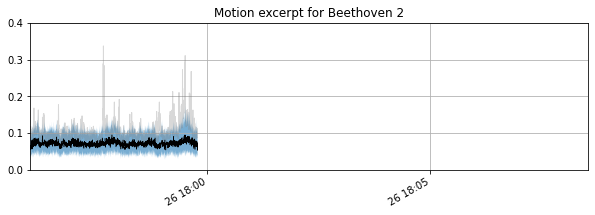

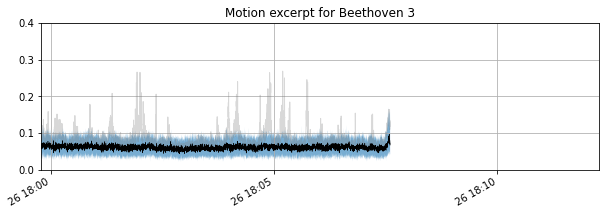

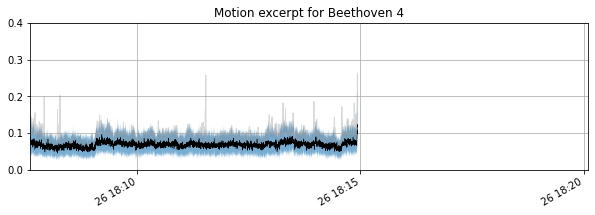

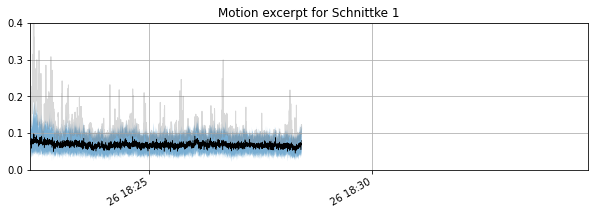

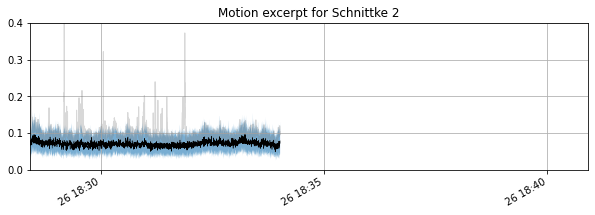

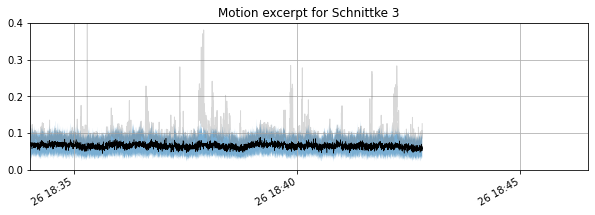

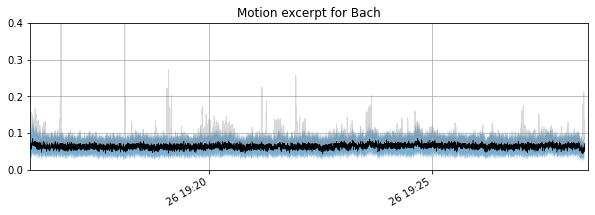

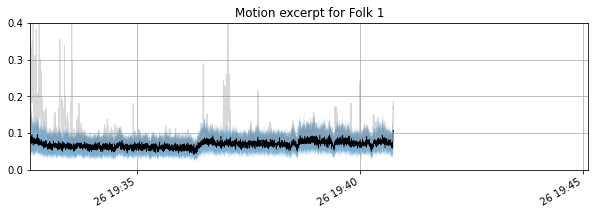

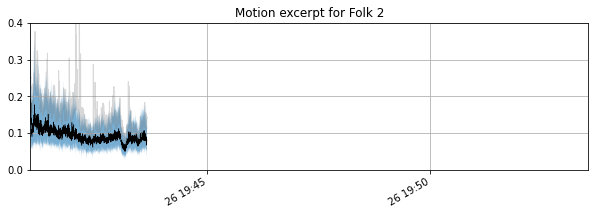

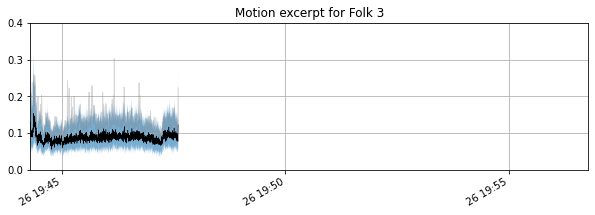

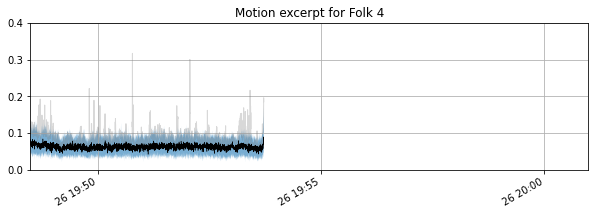

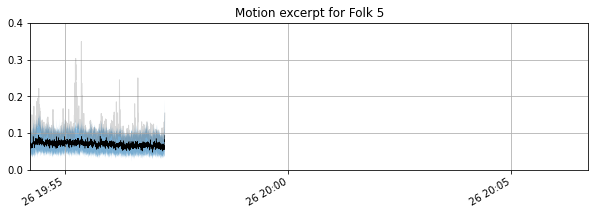

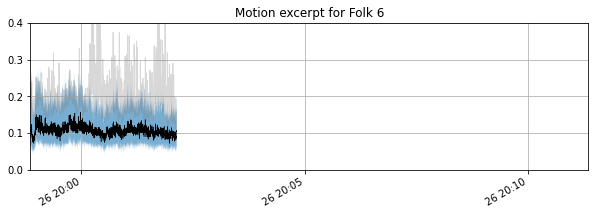

In [155]:
for k,seg in Mus_DF.items():
    #seg.plot(figsize=[8,3],legend=False,alpha = 0.2)
    ax = seg.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=[10,3])
    xrange = [seg.index[0], seg.index[0]+pd.Timedelta(seconds=750)]
    plt.ylim([0,0.4])
    plt.xlim(xrange)
    plt.title('Motion excerpt for ' + k)
    x = np.array(seg.index)
    y1 = np.array(seg.quantile(q=0.25,axis = 1),dtype=np.float32)
    y2 = np.array(seg.quantile(q=0.75,axis = 1),dtype=np.float32)
    seg.median(axis=1).plot(color='k',linewidth=0.5)
    ax.fill_between(x,y1,y2,alpha = 0.6)
    plt.grid()
    #plt.savefig('plots/Sample_pair.png',dpi=400)
    plt.show()


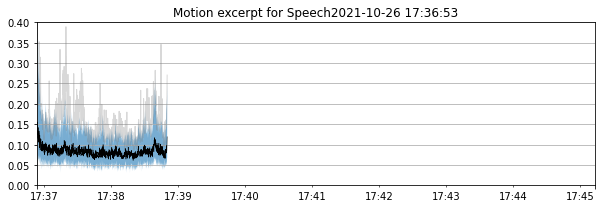

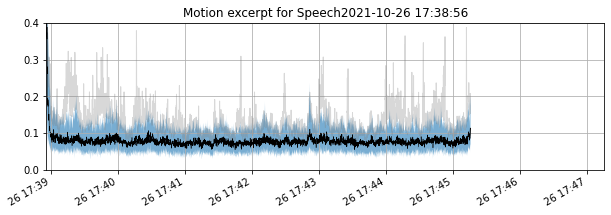

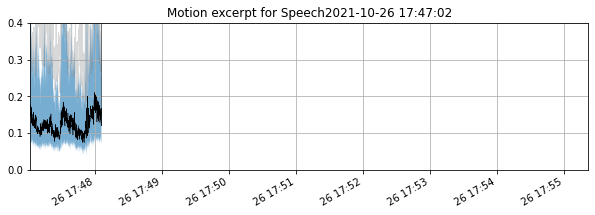

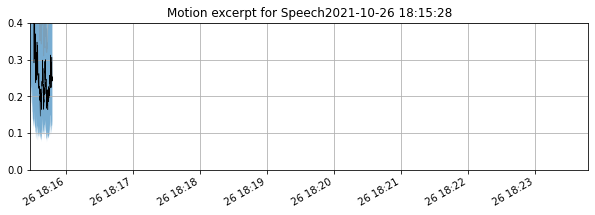

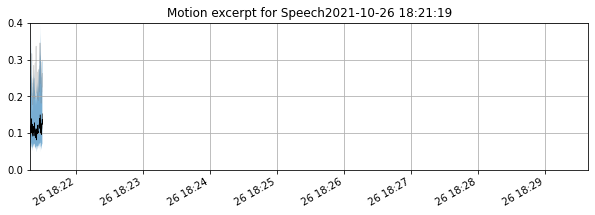

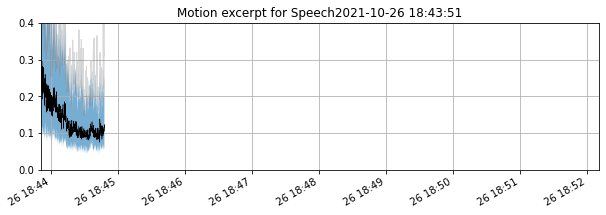

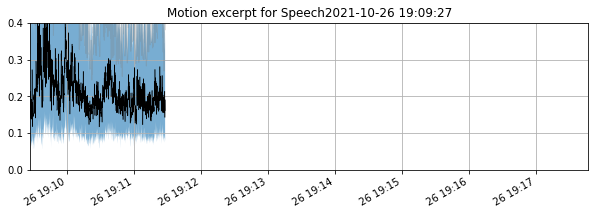

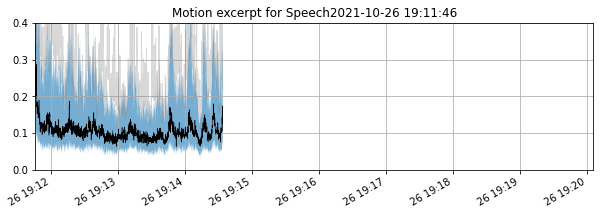

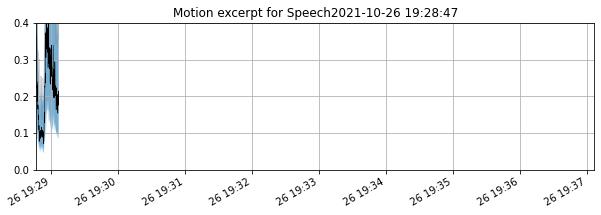

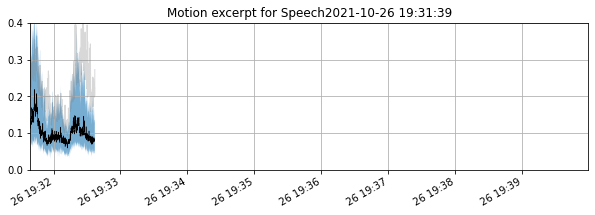

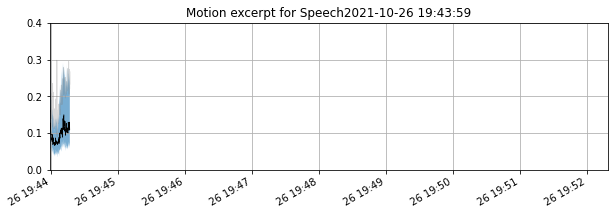

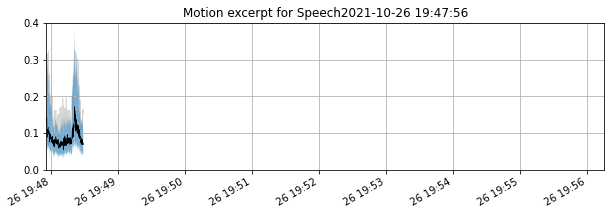

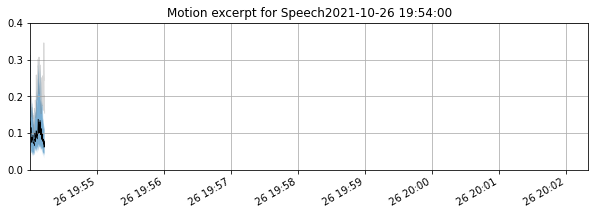

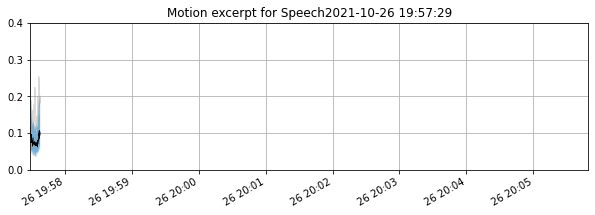

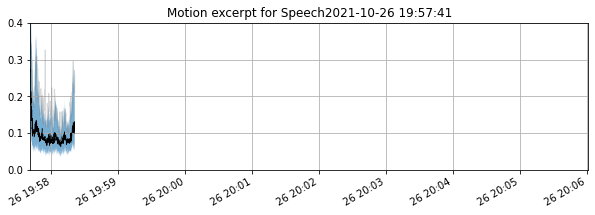

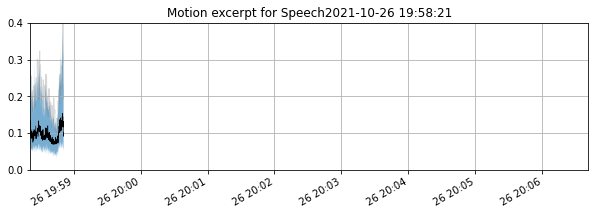

In [156]:

for k,seg in Spe_DF.items():
    #seg.plot(figsize=[8,3],legend=False,alpha = 0.2)
    ax = seg.mean(axis=1).plot(color='grey',linewidth=1,alpha = 0.3,figsize=[10,3])
    x = np.array(seg.index)
    y1 = np.array(seg.quantile(q=0.25,axis = 1),dtype=np.float32)
    y2 = np.array(seg.quantile(q=0.75,axis = 1),dtype=np.float32)
    seg.median(axis=1).plot(color='k',linewidth=0.5)
    ax.fill_between(x,y1,y2,alpha = 0.6)
    plt.grid()
    
    xrange = [seg.index[0], seg.index[0]+pd.Timedelta(seconds=500)]
    plt.ylim([0,0.4])
    plt.xlim(xrange)
    plt.title('Motion excerpt for ' + k)
    #plt.savefig('plots/Sample_pair.png',dpi=400)
    plt.show()


## Check out questionnair responses

In [159]:
public_Part

'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Public/Participants/'

In [160]:
# pull audience questionnair responses
Quest_df = pd.read_csv(public_Part + 'Questionnaire_Responses.csv',sep=',', encoding='latin-1')
Quest_df = Quest_df.loc[Quest_df['ParticipantCode'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Quest_df

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
0,AEQ086,NaN,Woman,Music-loving nonmusician,No_Relation,1.0,3.0,2.0,5.0,2.0,...,NaN,4.000000,4.000000,85,1.4,1.1,1.4,4.333333,4.166667,4.333333
1,AEQ088,NaN,Man,Semiprofessional musician,Relative_Friend,6.0,2.0,3.0,4.0,2.0,...,NaN,3.142857,3.166667,108,2.9,4.2,3.2,4.666667,4.833333,4.666667
2,AEQ077,24.0,Woman,Professional musician,No_Relation,5.0,5.0,1.0,4.0,1.0,...,NaN,4.857143,4.833333,159,4.1,3.9,5.0,4.500000,5.666667,6.333333
3,AEQ081,46.0,Man,Music-loving nonmusician,No_Relation,6.0,4.0,4.0,5.0,3.0,...,NaN,3.714286,3.666667,130,2.8,2.9,4.0,5.500000,6.500000,5.000000
4,AEQ079,71.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,4.0,4.0,2.0,...,NaN,4.285714,4.166667,141,5.2,3.0,2.6,5.000000,6.000000,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2.6,2.7,NaN,2.500000,3.333333,NaN
108,BEQ095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,133,4.0,0.6,3.0,3.666667,4.000000,3.666667
109,BEQ115,26.0,Woman,Professional musician,No_Relation,4.0,5.0,2.0,5.0,1.0,...,NaN,4.571429,4.666667,0,3.0,NaN,NaN,3.833333,NaN,NaN
110,BDQ092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1.8,1.6,NaN,4.166667,4.333333,NaN


In [161]:
Quest_text = pd.read_csv(public_Part + 'Codebook.csv', delimiter=",", encoding='latin-1')
Quest_text

,ID,English_Q,Danish_Q
0,NR,NR,NR
1,userID,userID,userID
2,city,Please specify the city you are streaming from:,Specificér venligst hvilken by du streamer fra
3,viewing_with_others,Are you viewing the concert with anyone you know?,Ser du koncerten med nogen du kender?
4,age,What is your age?,Hvad er din alder?
...,...,...,...
128,AIMS_32,I sometimes close my eyes so I can focus on th...,"Jeg lukker nogle gange mine øjne, så jeg kan f..."
129,AIMS_33,There are times when I will do nothing except ...,Nogle gange laver jeg ikke andet end end at ly...
130,AIMS_34,I sometimes feel like I'm part of something bi...,Jeg føler det nogle gange som om jeg er en del...
131,Comments,If you have any comments or impressions you wo...,Hvis du har nogle kommentarer eller indtryk du...


In [162]:
df = Quest_df
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
4,personal_relation,2
197,language,2
198,group,2
200,viewing_with_others,2
113,negative_Folk,3
...,...,...
215,KM_Folk,46
214,KM_Schnittke,48
1,age,51
212,AIMS,67


In [133]:
print(list(Quest_df.columns))

['ParticipantCode', 'age', 'gender', 'musician_status', 'personal_relation', 'fan', 'EC_1', 'EC_2', 'EC_3', 'EC_4', 'EC_5', 'EC_6', 'EC_7', 'tears_Beethoven', 'chills_Beethoven', 'warm_feeling_Beethoven', 'choked_up_Beethoven', 'refreshed_Beethoven', 'welcoming_Beethoven', 'closeness_Beethoven', 'positive_Beethoven', 'negative_Beethoven', 'tense_Beethoven', 'relaxed_Beethoven', 'alone_Beethoven', 'untouched_Beethoven', 'moved_Beethoven', 'touched_Beethoven', 'admiration_Beethoven', 'presence_grand_Beethoven', 'greater_than_myself_Beethoven', 'jaw_drop_Beethoven', 'gasped_Beethoven', 'challenge_process_Beethoven', 'hard_comprehend_Beethoven', 'others_moved_Beethoven', 'connected_musicians_Beethoven', 'connected_audience_Beethoven', 'enjoy_Beethoven', 'familiar_Beethoven', 'own_world_Beethoven', 'absorbed_music_Beethoven', 'daydream_Beethoven', 'sense_time_Beethoven', 'distracted_Beethoven', 'attentive_Beethoven', 'attention_others_Beethoven', 'attention_sensations_Beethoven', 'positivel

In [163]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body', 'aware_movement', 'aware_others_moving', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']
sub_Q = Quest_df[sub_Q_List].copy()
sub_Q

,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body,aware_movement,aware_others_moving,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,AEQ086,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved a normal amount
1,AEQ088,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Not aware of movement,Not aware of others movement,Rarely,Yes and I moved a normal amount,Not aware of others movement
2,AEQ077,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,Not at all,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Yes and they moved a normal amount
3,AEQ081,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,AEQ079,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,Intermittently,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Not aware of others movement,NaN,NaN,NaN,NaN,NaN,NaN
108,BEQ095,Intermittently,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Not aware of others movement,Intermittently,Yes and I moved less than usual,Not aware of others movement,Continuously,Yes and I moved a normal amount,Not aware of others movement
109,BEQ115,Intermittently,Yes and I moved a normal amount,Not aware of others movement,NaN,NaN,NaN,Rarely,Not aware of movement,Not aware of others movement,NaN,NaN,NaN
110,BDQ092,Rarely,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved less than usual,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,NaN,NaN,NaN


<AxesSubplot:>

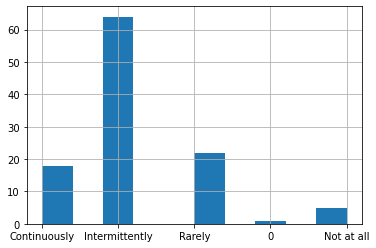

In [164]:
c = 'aware_body_Beethoven'
sub_Q[c].hist()

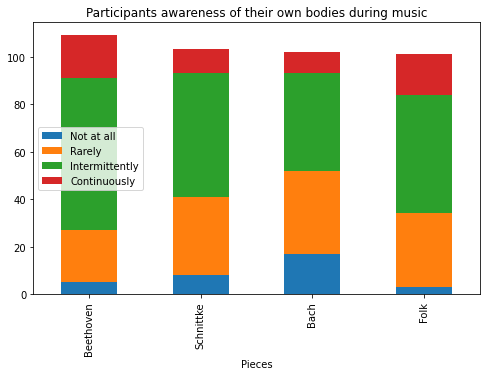

In [165]:
Cols = ['aware_body_Beethoven','aware_body_Schnittke','aware_body','aware_body_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()

sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df.drop('0',axis = 1,inplace=True)
sub_hist_df = sub_hist_df.iloc[:,:4]
sub_hist_df = sub_hist_df.loc[:,[ 'Not at all', 'Rarely', 'Intermittently','Continuously']]
#stacked_data = sub_hist_df.apply(lambda x: x*100/sum(x), axis=1)
sub_hist_df.plot(kind='bar',stacked=True,figsize=[8,5])
plt.legend(loc = 'center left')
plt.title('Participants awareness of their own bodies during music')
plt.show()


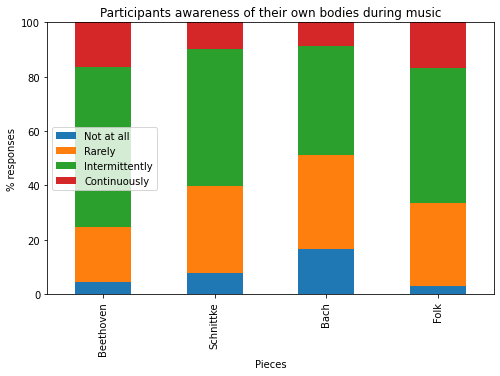

In [166]:
stacked_data = sub_hist_df.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,figsize=[8,5])
plt.ylabel('% responses')
plt.ylim([0,100])
plt.legend(loc = 'center left')
plt.title('Participants awareness of their own bodies during music')
plt.show()

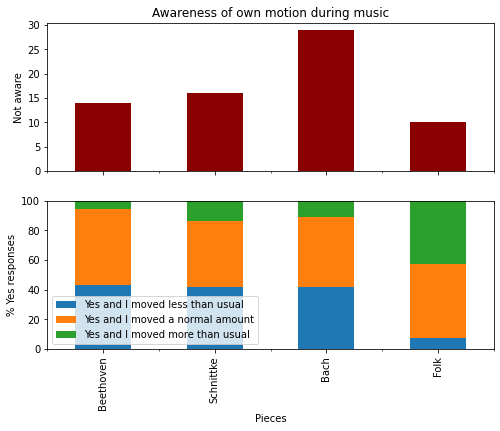

In [167]:
Cols = ['aware_movement_Beethoven','aware_movement_Schnittke','aware_movement','aware_movement_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()
    
sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df = sub_hist_df.iloc[:,:4]
sub_hist_df = sub_hist_df.loc[:,['Yes and I moved less than usual', 'Yes and I moved a normal amount','Yes and I moved more than usual','Not aware of movement']]

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=[8,6])
sub_hist_df.iloc[:,3].plot(kind='bar',color = 'darkred',ax = ax1)
ax1.set_ylabel('Not aware')
ax1.set_title('Awareness of own motion during music')
#sub_hist_df.iloc[:,:3].plot(kind='bar',stacked=True,ax = ax2)

stacked_data = sub_hist_df.iloc[:,:3].apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,ax = ax2)
ax2.set_ylabel('% Yes responses')
ax2.set_ylim([0,100])
ax2.legend(loc = 'lower left')
plt.show()


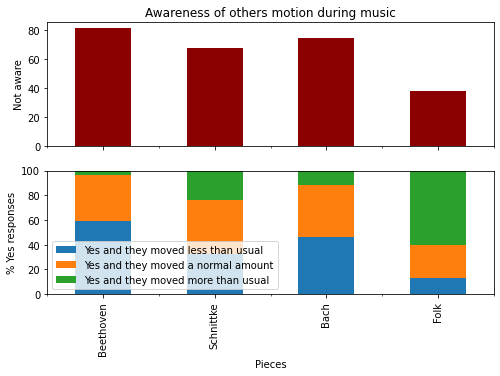

In [168]:
Cols = ['aware_others_moving_Beethoven','aware_others_moving_Schnittke','aware_others_moving','aware_others_moving_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()
    
sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df = sub_hist_df.iloc[:,:4]


sub_hist_df = sub_hist_df.loc[:,['Yes and they moved less than usual','Yes and they moved a normal amount',
'Yes and they moved more than usual','Not aware of others movement']]

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=[8,5])
sub_hist_df.iloc[:,3].plot(kind='bar',color = 'darkred',ax = ax1)
ax1.set_ylabel('Not aware')
ax1.set_title('Awareness of others motion during music')
stacked_data = sub_hist_df.iloc[:,:3].apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,ax = ax2)
ax2.set_ylabel('% Yes responses')
ax2.set_ylim([0,100])
ax2.legend(loc = 'lower left')
plt.show()

### TODO

Normalise motion between participants

evaluate stats re motion per piece


In [170]:
A

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ103,BEQ105,BEQ106,BEQ107,BEQ108,BEQ109,BEQ110,BEQ111,BEQ112,BEQ113
ADQ001,1.000000,0.154253,0.219673,0.233792,0.165074,0.082956,0.229116,0.127333,0.173362,0.061213,...,-0.034018,-0.195317,0.020219,-0.088888,-0.045372,0.048549,-0.210416,0.002921,0.103115,-0.088660
ADQ002,0.154253,1.000000,0.325776,0.160836,0.219090,0.101955,0.160784,0.159460,0.200883,0.050798,...,0.048183,-0.082207,0.056756,0.042099,-0.041839,0.018287,-0.048216,0.009975,0.237835,-0.096443
ADQ003,0.219673,0.325776,1.000000,0.296638,0.249245,0.093671,0.320671,0.239852,0.384756,0.081965,...,0.229376,-0.196252,0.099564,0.023820,-0.002375,0.028872,-0.196920,-0.033019,0.036335,-0.018882
ADQ004,0.233792,0.160836,0.296638,1.000000,0.154993,0.036900,0.182422,0.087686,0.107666,-0.027809,...,-0.040282,-0.249361,0.127045,0.123838,-0.018898,0.043582,-0.092819,-0.018121,0.310190,-0.078207
ADQ005,0.165074,0.219090,0.249245,0.154993,1.000000,0.076272,0.231503,0.078381,0.141331,0.080148,...,-0.074359,-0.190111,0.090182,-0.029160,-0.019159,0.085826,-0.149834,-0.080274,-0.027080,-0.000768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BEQ109,0.048549,0.018287,0.028872,0.043582,0.085826,0.043501,0.036944,-0.028611,0.007029,-0.008686,...,0.024020,-0.148650,0.078861,0.143303,0.192985,1.000000,-0.012470,0.200421,0.009459,0.405594
BEQ110,-0.210416,-0.048216,-0.196920,-0.092819,-0.149834,0.085278,-0.214156,-0.176764,-0.119863,-0.018598,...,-0.029443,0.382716,-0.017217,0.312612,-0.005868,-0.012470,1.000000,-0.107427,0.317572,0.077287
BEQ111,0.002921,0.009975,-0.033019,-0.018121,-0.080274,0.030339,0.069621,0.062339,-0.005345,0.016275,...,-0.005520,-0.031535,0.013517,-0.164753,-0.054814,0.200421,-0.107427,1.000000,0.019931,0.248866
BEQ112,0.103115,0.237835,0.036335,0.310190,-0.027080,0.174647,-0.020997,-0.183345,0.160266,0.159477,...,-0.096291,-0.086049,0.058230,0.395129,0.007164,0.009459,0.317572,0.019931,1.000000,-0.037672


In [169]:
# generate a dataframe to combine questionnair results and motion statistics 

# like this example?
A = seg_df.corr(method = 'spearman')
Sub_Rels['Seg_Corr'] = 51
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

KeyError: 'ADQ021'

In [270]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


In [272]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


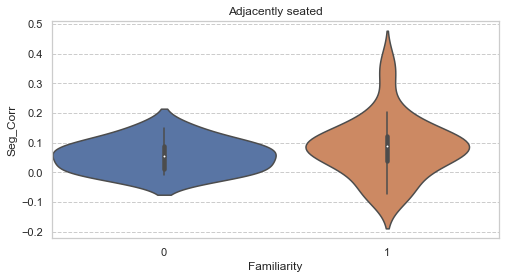

        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1     39  0.780087  0.382527  0.01961


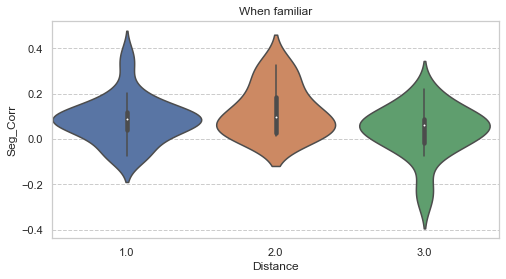

     Source  ddof1  ddof2        F     p-unc       np2
0  Distance      2     61  2.83887  0.066243  0.085152


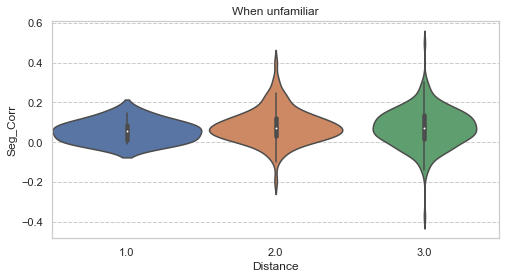

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    393  0.500615  0.606544  0.002541


In [273]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.violinplot(x = 'Familiarity',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When familiar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

In [274]:
concert_times = pd.read_csv(public_time +'Events_Coarse.csv',",") #SV alignment for beeps

# concert_times.drop(concert_times.iloc[61].name,inplace=True)
# concert_times.drop(concert_times.iloc[22].name,inplace=True)
# concert_times.drop(concert_times.iloc[16].name,inplace=True)
concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('datetime')

# replace some of the terms
# event_type Audience Group to Applause, change Clapping to 


In [275]:
Main_concert_times.iloc[:10]

,time_s,time,events,event_type,Stream_Time_s,Event Duration,sequence
datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,MCing,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,MCing,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,MCing,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [276]:
corrs_set = pd.DataFrame()
for i in range(len(Main_concert_times)-1):
    als = Sub_Rels.copy()
    row = Main_concert_times.iloc[i]
    if row['Event Duration'] >15:
        seg_start = Main_concert_times.iloc[i].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
        seg_end = Main_concert_times.iloc[i+1].name
        print(str([seg_start,seg_end]) + ': ' + row['events'] + ', ' + row['event_type'])
        corr_name = 'Seg_corr'#
        als['Seg_N'] = row['sequence']
        als['Seg_event'] = row['events']
        als['Seg_type'] = row['event_type']
        als['Seg_dur'] = row['Event Duration']
        als[corr_name] = 0
        seg_df = aud_df.loc[seg_start:seg_end]
        #seg_df = seg_df.fillna(0)
        A = seg_df.corr(method = 'spearman')

        for i,row in Sub_Rels.iterrows():
            if row['Participant_Code_1'] in seg_df.columns:
                if row['Participant_Code_2'] in seg_df.columns:
                    als.loc[i,corr_name] = A[row['Participant_Code_1']][row['Participant_Code_2']]
        corrs_set = pd.concat([corrs_set,als],ignore_index=True)


['2021-10-26 17:36:35', '2021-10-26 17:36:53']: Clapping for MC, Applause
['2021-10-26 17:36:53', '2021-10-26 17:38:50']: Speech, MCing
['2021-10-26 17:38:56', '2021-10-26 17:45:16']: Speech, MCing
['2021-10-26 17:45:16', '2021-10-26 17:47:02']: Clapping for MC, Applause
['2021-10-26 17:47:02', '2021-10-26 17:48:06']: Speech, MCing
['2021-10-26 17:48:20', '2021-10-26 17:49:03']: Clapping for musicians, Applause
['2021-10-26 17:49:03', '2021-10-26 17:56:02']: Beethoven 1, Music
['2021-10-26 17:56:02', '2021-10-26 17:59:47']: Beethoven 2, Music
['2021-10-26 17:59:47', '2021-10-26 18:07:36']: Beethoven 3, Music
['2021-10-26 18:07:36', '2021-10-26 18:14:56']: Beethoven 4, Music
['2021-10-26 18:14:56', '2021-10-26 18:15:28']: Clapping for Beethoven, Applause
['2021-10-26 18:15:28', '2021-10-26 18:15:48']: Speech, MCing
['2021-10-26 18:15:48', '2021-10-26 18:21:19']: Survey for Beethoven, Survey
['2021-10-26 18:21:30', '2021-10-26 18:22:20']: Clapping for Musicians, Applause
['2021-10-26 18:

In [203]:
corrs_set['Distance']= corrs_set['Distance'].abs()

In [221]:
sns.set(rc={'figure.figsize':(7,3)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

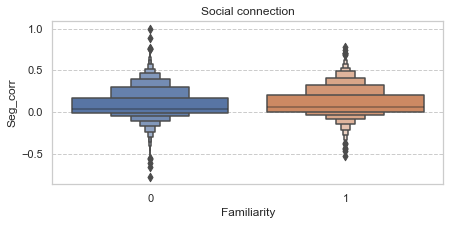

        Source  ddof1  ddof2          F         p-unc       np2
0  Familiarity      1  21378  36.330702  1.692492e-09  0.001697


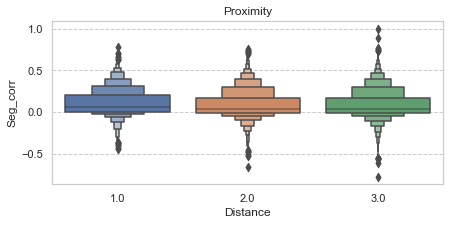

     Source  ddof1  ddof2          F         p-unc       np2
0  Distance      2  21377  14.391377  5.676861e-07  0.001345


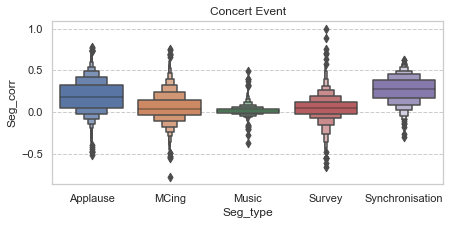

     Source  ddof1  ddof2            F  p-unc       np2
0  Seg_type      4  21375  1519.961304    0.0  0.221449


In [222]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")

sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = corrs_set)
plt.title('Social connection')
plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=corrs_set)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr', data = corrs_set)
plt.title('Proximity')
plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=corrs_set)
print(aov)

sns.boxenplot(x = 'Seg_type',y = 'Seg_corr', data = corrs_set)
plt.title('Concert Event')
plt.savefig('plots/PairCorr_allEvents_EventType.png',dpi = 400)

plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_type", data=corrs_set)
print(aov)


In [223]:
pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_type'], data=corrs_set)

,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.305635,1.0,0.305635,14.454660,0.000144,0.000677
1,Distance,0.162202,2.0,0.081101,3.835581,0.021604,0.000359
2,Seg_type,128.899240,4.0,32.224810,1524.033631,0.000000,0.222113
3,Familiarity * Distance,0.110526,2.0,0.055263,2.613602,0.073294,0.000245
4,Familiarity * Seg_type,0.272405,4.0,0.068101,3.220762,0.011878,0.000603
5,Distance * Seg_type,0.071650,8.0,0.008956,0.423576,0.907646,0.000159
6,Familiarity * Distance * Seg_type,0.218908,8.0,0.027363,1.294124,0.241188,0.000485
7,Residual,451.433407,21350.0,0.021144,NaN,NaN,NaN


In [225]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

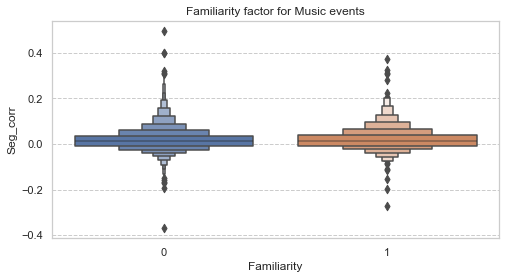

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6718  3.909795  0.048046  0.000582


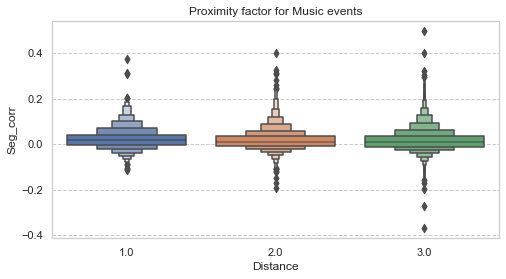

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6717  6.503772  0.001507  0.001933


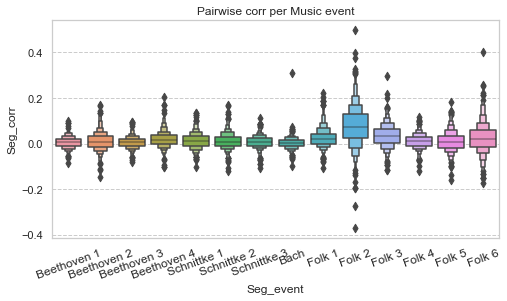

      Source  ddof1  ddof2          F          p-unc      np2
0  Seg_event     13   6706  83.167024  3.608196e-206  0.13884


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.000136,1.0,0.000136,0.068405,7.936818e-01,0.000010
1,Distance,0.021859,2.0,0.010930,5.492822,4.134950e-03,0.001653
2,Seg_event,2.165829,13.0,0.166602,83.727119,2.354073e-207,0.140910
3,Familiarity * Distance,0.007587,2.0,0.003794,1.906498,1.486813e-01,0.000574
4,Familiarity * Seg_event,0.041308,13.0,0.003178,1.596882,7.814392e-02,0.003119
5,Distance * Seg_event,0.085981,26.0,0.003307,1.661939,1.863138e-02,0.006469
6,Familiarity * Distance * Seg_event,0.081157,26.0,0.003121,1.568697,3.299413e-02,0.006109
7,Residual,13.204473,6636.0,0.001990,NaN,NaN,NaN


In [226]:
# look at within type patters
Ev = 'Music'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

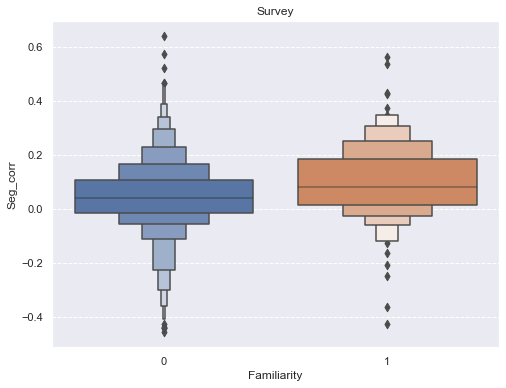

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   1343  24.093733  0.000001  0.017624


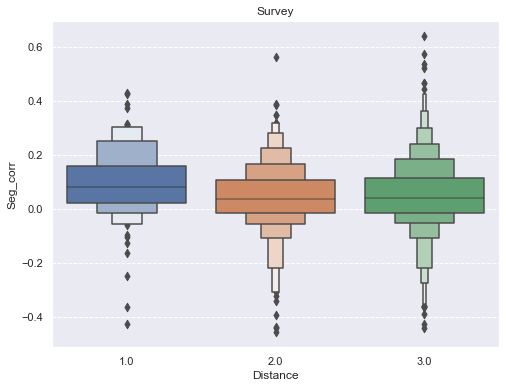

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   1342  7.158177  0.000809  0.010555


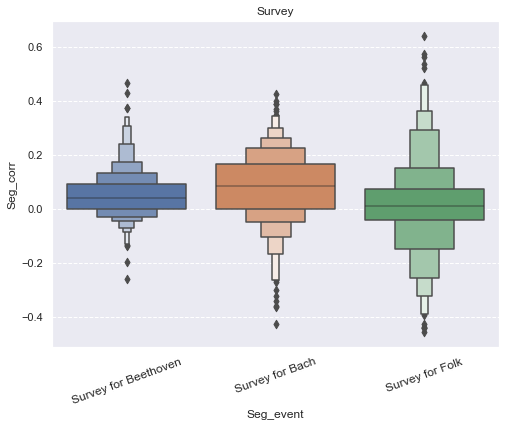

      Source  ddof1  ddof2          F         p-unc       np2
0  Seg_event      2   1342  27.690735  1.642807e-12  0.039632


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.146430,1.0,0.146430,9.876679,1.710920e-03,0.007388
1,Distance,0.027649,2.0,0.013825,0.932472,3.938371e-01,0.001403
2,Seg_event,0.830461,2.0,0.415230,28.007217,1.219926e-12,0.040502
3,Familiarity * Distance,0.077585,2.0,0.038793,2.616556,7.343088e-02,0.003928
4,Familiarity * Seg_event,0.112846,2.0,0.056423,3.805719,2.248637e-02,0.005703
5,Distance * Seg_event,0.060894,4.0,0.015224,1.026823,3.921092e-01,0.003086
6,Familiarity * Distance * Seg_event,0.373457,4.0,0.093364,6.297395,5.096022e-05,0.018629
7,Residual,19.673882,1327.0,0.014826,NaN,NaN,NaN


In [177]:
# look at within type patters
Ev = 'Survey'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

In [185]:
corrs_set[corrs_set['Seg_event'] == Ev]

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Seg_N,Seg_event,Seg_type,Seg_dur,Seg_corr


In [183]:
# look at within type patters
Ev = 'Applause'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_event'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

ValueError: min() arg is an empty sequence

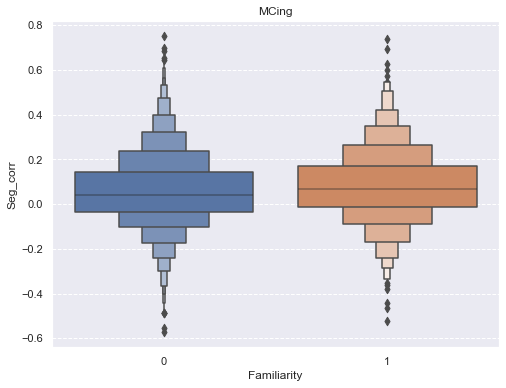

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   5582  12.615124  0.000386  0.002255


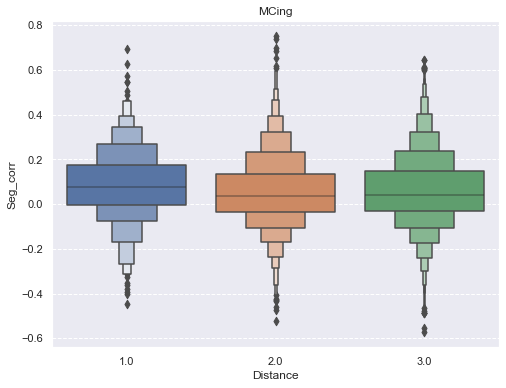

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   5581  6.614581  0.001351  0.002365


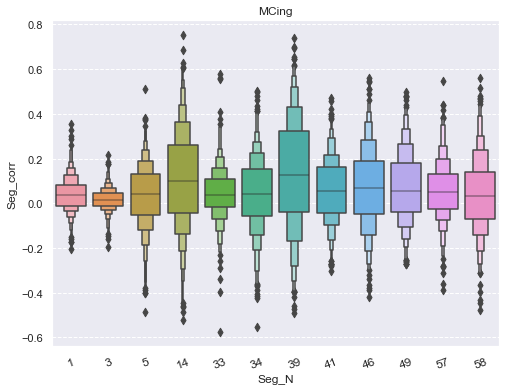

  Source  ddof1  ddof2          F         p-unc       np2
0  Seg_N     11   5572  20.794515  6.402947e-42  0.039433


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.088744,1.0,0.088744,3.518235,6.074988e-02,0.000638
1,Distance,0.101602,2.0,0.050801,2.014005,1.335513e-01,0.000730
2,Seg_N,5.798593,11.0,0.527145,20.898570,3.861304e-42,0.040036
3,Familiarity * Distance,0.151283,2.0,0.075642,2.998796,4.992840e-02,0.001087
4,Familiarity * Seg_N,0.548136,11.0,0.049831,1.975525,2.675454e-02,0.003927
5,Distance * Seg_N,0.603042,22.0,0.027411,1.086705,3.525430e-01,0.004319
6,Familiarity * Distance * Seg_N,0.588216,22.0,0.026737,1.059988,3.842545e-01,0.004213
7,Residual,139.034493,5512.0,0.025224,NaN,NaN,NaN


In [150]:
# look at within type patters
Ev = 'MCing'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

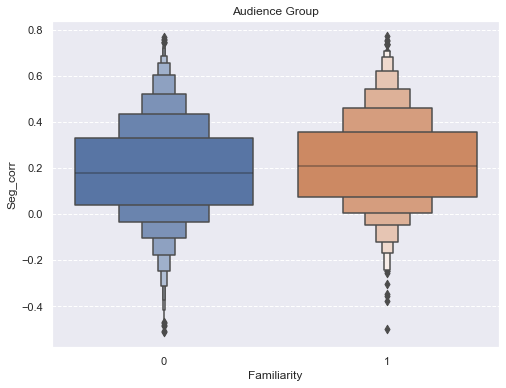

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   7010  17.814801  0.000025  0.002535


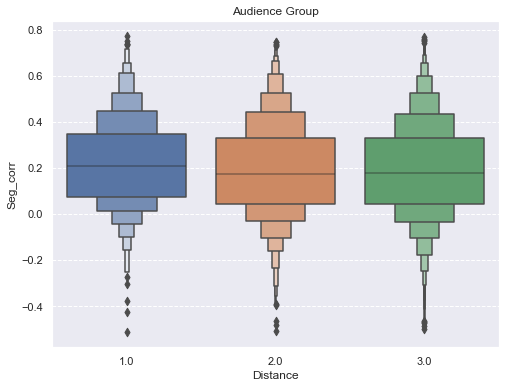

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   7009  4.677732  0.009329  0.001333


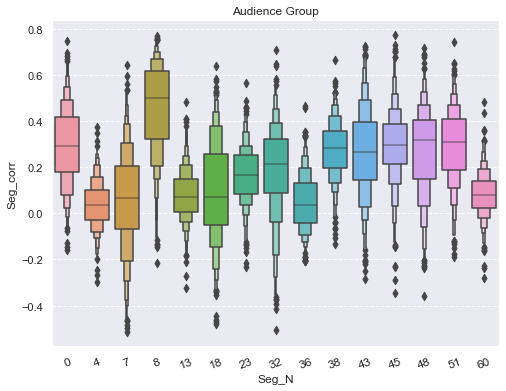

  Source  ddof1  ddof2           F  p-unc       np2
0  Seg_N     14   6997  291.922613    0.0  0.368725


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.397796,1.0,0.397796,14.750684,0.000124,0.002126
1,Distance,0.036178,2.0,0.018089,0.670756,0.511355,0.000194
2,Seg_N,110.486072,14.0,7.891862,292.638201,0.000000,0.371809
3,Familiarity * Distance,0.164154,2.0,0.082077,3.043505,0.047731,0.000879
4,Familiarity * Seg_N,0.430641,14.0,0.030760,1.140615,0.315575,0.002302
5,Distance * Seg_N,0.705743,28.0,0.025205,0.934631,0.563736,0.003766
6,Familiarity * Distance * Seg_N,0.521445,28.0,0.018623,0.690561,0.887154,0.002786
7,Residual,186.672384,6922.0,0.026968,NaN,NaN,NaN


In [151]:
# look at within type patters
Ev = 'Audience Group'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

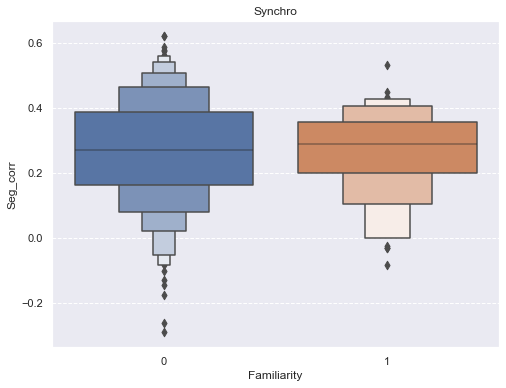

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    461  0.063511  0.801143  0.000138


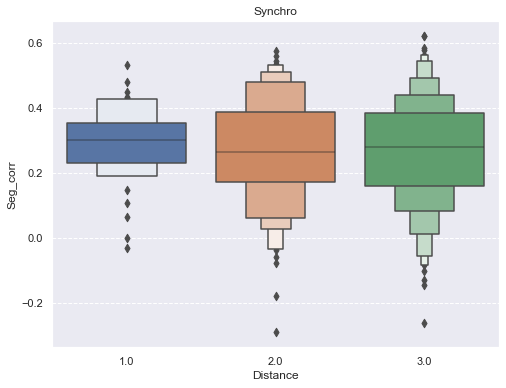

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    460  0.390087  0.677222  0.001693


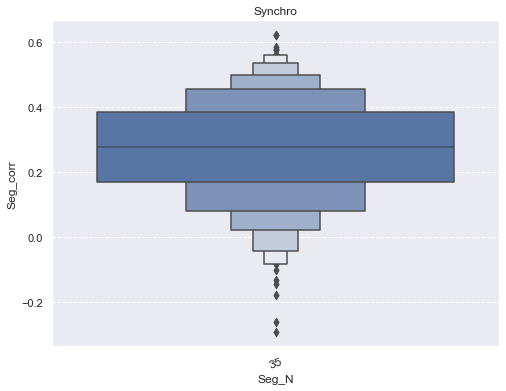

  Source  ddof1  ddof2  np2
0  Seg_N      0    462  0.0


C:\Users\finnu\Anaconda3\lib\site-packages\pingouin\parametric.py:979: RuntimeWarning: invalid value encountered in double_scalars
  msbetween = ssbetween / ddof1


ValueError: must have at least one row in constraint matrix

In [154]:
# look at within type patters
Ev = 'Synchronisation'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)